In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mlp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
mlp.rcParams['lines.linewidth'] = 5
mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

## Sberbank Russian Housing Market

In [3]:
pd.options.display.max_columns = 500

df = pd.read_csv("train.csv")

In [4]:
# these ids describe the location of the apartment, and we already have such columns

df = df.drop(['ID_metro',
 'ID_railroad_station_walk',
 'ID_railroad_station_avto',
 'ID_big_road1',
 'ID_big_road2',
 'ID_railroad_terminal',
 'ID_bus_terminal'], axis=1)

In [5]:
df = df.drop('id', axis=1)

print(df.shape)

df.head()

(30471, 284)


,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_150

### Metric - RMSLE. In fact, it's the root of MSLE, so it doesn't matter which one you optimize!

In [6]:
df = df.assign(log_price_doc=np.log1p(df['price_doc']))
df = df.drop('price_doc', axis=1)

In [7]:
df

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_150

### Working with passes and EDA elements

In [8]:
np.object = object

In [9]:
### Let's look at non-categorical columns

numeric_columns = df.loc[:,df.dtypes!=np.object].columns

df.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road2_km,railroad_km,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,market_count_2000,green_part_3000,prom_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,

In [10]:
### Fill with average

for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

In [11]:
### Let's study the correlations of real features

df[numeric_columns].corr()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road2_km,railroad_km,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,market_count_2000,green_part_3000,prom_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,

In [12]:
### Secret functions for filtering features

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_columns], 50))

Top Absolute Correlations

railroad_station_walk_km              railroad_station_walk_min                1.000000

public_transport_station_km           public_transport_station_min_walk        1.000000

children_school                       7_14_all                                 1.000000

children_preschool                    0_6_all                                  1.000000

metro_min_walk                        metro_km_walk                            1.000000

raion_build_count_with_material_info  raion_build_count_with_builddate_info    0.999990

young_all                             0_13_all                                 0.999885

young_female                          0_13_female                              0.999871

young_male                            0_13_male                                0.999861

full_all                              female_f                                 0.999850

                                      male_f                                   0.99

In [13]:
### Let's remove columns where the correlation is > 0.9

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    
correlation(df, 0.9)

In [14]:
numeric_columns = df.loc[:,df.dtypes!=np.object].columns

df.shape

(30471, 150)

In [15]:
### Let's look at quasi-constant signs

cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[numeric_columns])
constant_cols = [x for x in numeric_columns if x not in cutter.get_feature_names_out()]

df[constant_cols]

,green_zone_part,indust_part,green_zone_km,cafe_count_500_price_high,mosque_count_500,mosque_count_1000,mosque_count_1500,mosque_count_2000
0,0.189727,0.000070,0.600973,0,0,0,0,0
1,0.372602,0.049637,0.065321,0,0,0,0,0
2,0.112560,0.118537,0.453172,0,0,0,0,0
3,0.194703,0.069753,0.106125,0,0,0,0,0
4,0.015234,0.037316,0.236214,0,0,0,0,0
...,...,...,...,...,...,...,...,...
30466,0.096270,0.300323,0.139814,0,0,0,0,1
30467,0.065444,0.000078,0.271861,0,0,0,0,0
30468,0.496315,0.007122,0.427248,0,0,0,0,0
30469,0.167526,0.093443,0.227547,0,0,0,0,0


In [16]:
### Let's look at the categorical columns

categorical_columns = df.loc[:,df.dtypes==np.object].columns

df.describe(include='object')

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
count,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471
unique,1161,2,146,2,2,2,2,2,2,2,2,2,2,2,2,5
top,2014-12-16,Investment,Poselenie Sosenskoe,no,no,no,no,no,no,no,no,no,no,no,no,poor
freq,160,19448,1776,28543,28817,28155,30175,19600,29335,27649,29608,27427,28134,29690,29578,8018


In [17]:
### Converting categorical columns

for col in categorical_columns:
    if col != 'timestamp': 
        if df[col].nunique() < 5:
            one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

        else:
            mean_target = df.groupby(col)['log_price_doc'].mean()
            df[col] = df[col].map(mean_target)

In [18]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_avto_min,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,big_road2_km,railroad_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,cafe_count_1500_price_high,mosque_count_1500,sport_count_1500,market_count_1500,prom_part_2000,office_sqm_2000,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,green_part_3000,prom_part_3000,trc_count_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes
0,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,2.590241,0.145700,0.177975,2.158587,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,6.905893,0.274985,0.992631,1.422391,10.918587,1.422391,3.830951,1.305159,24.292406,18.152338,5.718519,1.062513,5.814135,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,7.023705,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,0,6,1,14.27,9,171420,566.67,0,0,7,1,15.97,188854,1244891,614.29,0,1,11.98,13.55,23,1419204,639.68,0,21,1,13.09,13.31,29,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,0.936700,0.147754,0.273345,0.550690,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,4.679745,0.065263,0.698081,9.503405,3.103996,2.887377,3.103996,0.694536,5.706113,9.034642,3.489954,1.246149,3.419574,0.725560,6.910568,3.424716,0.668364,2.000154,8.972823,2.54374

In [19]:
### Let's work with the date

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['month'] = df.timestamp.dt.month
df['year'] = df.timestamp.dt.year

In [20]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_avto_min,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,big_road2_km,railroad_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,cafe_count_1500_price_high,mosque_count_1500,sport_count_1500,market_count_1500,prom_part_2000,office_sqm_2000,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,green_part_3000,prom_part_3000,trc_count_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,month,year
0,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,2.590241,0.145700,0.177975,2.158587,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,6.905893,0.274985,0.992631,1.422391,10.918587,1.422391,3.830951,1.305159,24.292406,18.152338,5.718519,1.062513,5.814135,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,7.023705,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,0,6,1,14.27,9,171420,566.67,0,0,7,1,15.97,188854,1244891,614.29,0,1,11.98,13.55,23,1419204,639.68,0,21,1,13.09,13.31,29,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2011
1,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,0.936700,0.147754,0.273345,0.550690,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,4.679745,0.065263,0.698081,9.503405,3.103996,2.887377,3.103996,0.694536,5.706113,9.034642,3.489954,1.246149,3.419574,0.725560,6.910568,3.424716,0.668364,2.00015

In [21]:
### Sort by timestamp

df = df.sort_values('timestamp')

df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_avto_min,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,big_road2_km,railroad_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,cafe_count_1500_price_high,mosque_count_1500,sport_count_1500,market_count_1500,prom_part_2000,office_sqm_2000,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,green_part_3000,prom_part_3000,trc_count_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,month,year
0,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,2.590241,0.145700,0.177975,2.158587,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,6.905893,0.274985,0.992631,1.422391,10.918587,1.422391,3.830951,1.305159,24.292406,18.152338,5.718519,1.062513,5.814135,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,7.023705,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,0,6,1,14.27,9,171420,566.67,0,0,7,1,15.97,188854,1244891,614.29,0,1,11.98,13.55,23,1419204,639.68,0,21,1,13.09,13.31,29,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2011
1,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,0.936700,0.147754,0.273345,0.550690,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,4.679745,0.065263,0.698081,9.503405,3.103996,2.887377,3.103996,0.694536,5.706113,9.034642,3.489954,1.246149,3.419574,0.725560,6.910568,3.424716,0.668364,2.00015

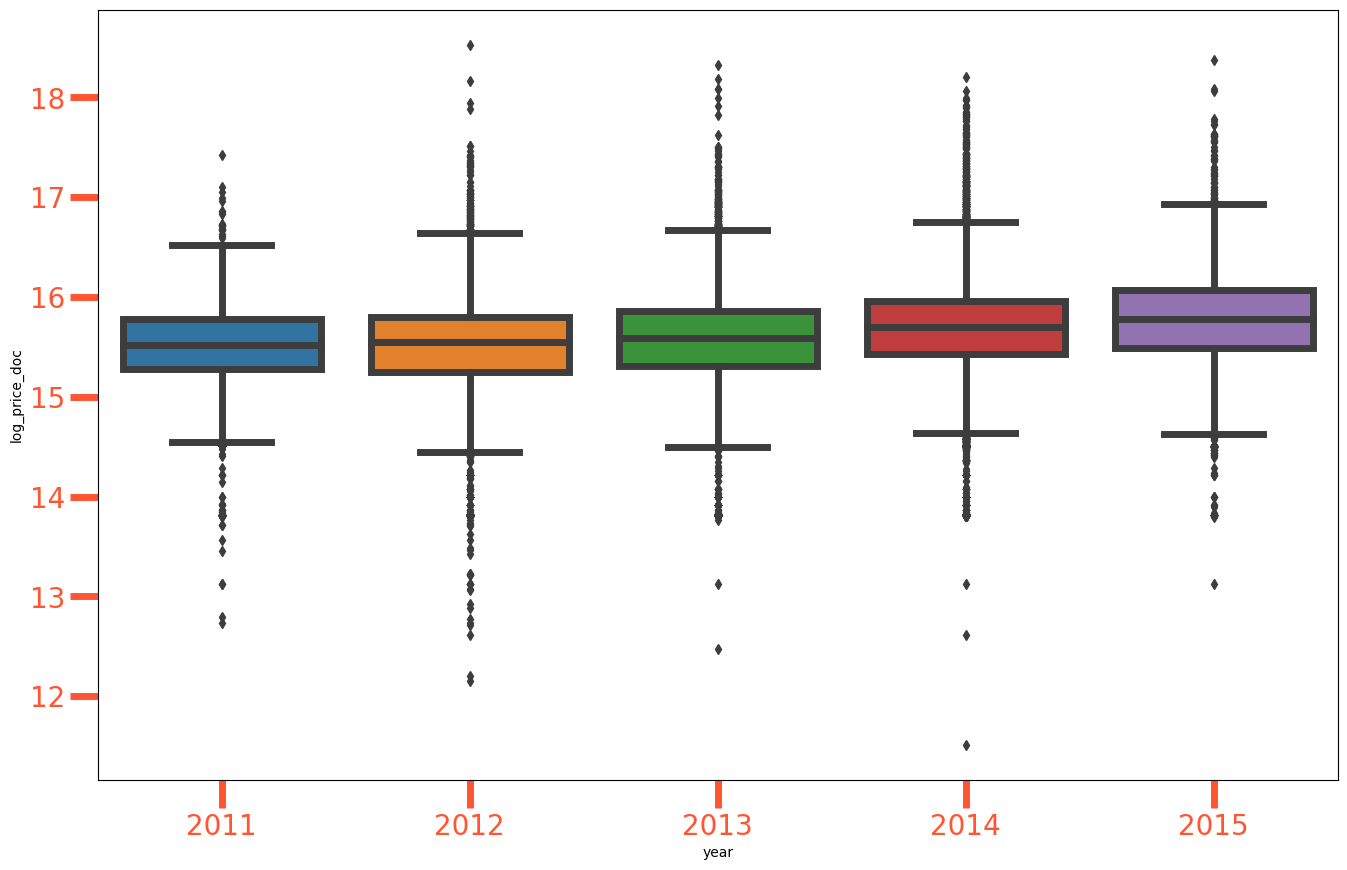

In [22]:
### target distribution by year

fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.boxplot(y='log_price_doc', x=df['year'].astype('category'), data=df)
plt.show()

In [23]:
### Let's encode the column with the year using One-Hot

one_hot = pd.get_dummies(df['year'], prefix='year', drop_first=True)
df = pd.concat((df.drop('year', axis=1), one_hot), axis=1)

In [24]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_avto_min,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,big_road2_km,railroad_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,cafe_count_1500_price_high,mosque_count_1500,sport_count_1500,market_count_1500,prom_part_2000,office_sqm_2000,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,green_part_3000,prom_part_3000,trc_count_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,month,year_2012,year_2013,year_2014,year_2015
0,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,2.590241,0.145700,0.177975,2.158587,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,6.905893,0.274985,0.992631,1.422391,10.918587,1.422391,3.830951,1.305159,24.292406,18.152338,5.718519,1.062513,5.814135,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,7.023705,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,0,6,1,14.27,9,171420,566.67,0,0,7,1,15.97,188854,1244891,614.29,0,1,11.98,13.55,23,1419204,639.68,0,21,1,13.09,13.31,29,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0
1,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,0.936700,0.147754,0.273345,0.550690,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,4.679745,0.065263,0.698081,9.503405,3.103996,2.887377,3.103996,0.694536,5.706113,9.034642,3.489954,1.246149,3.419574,0.725

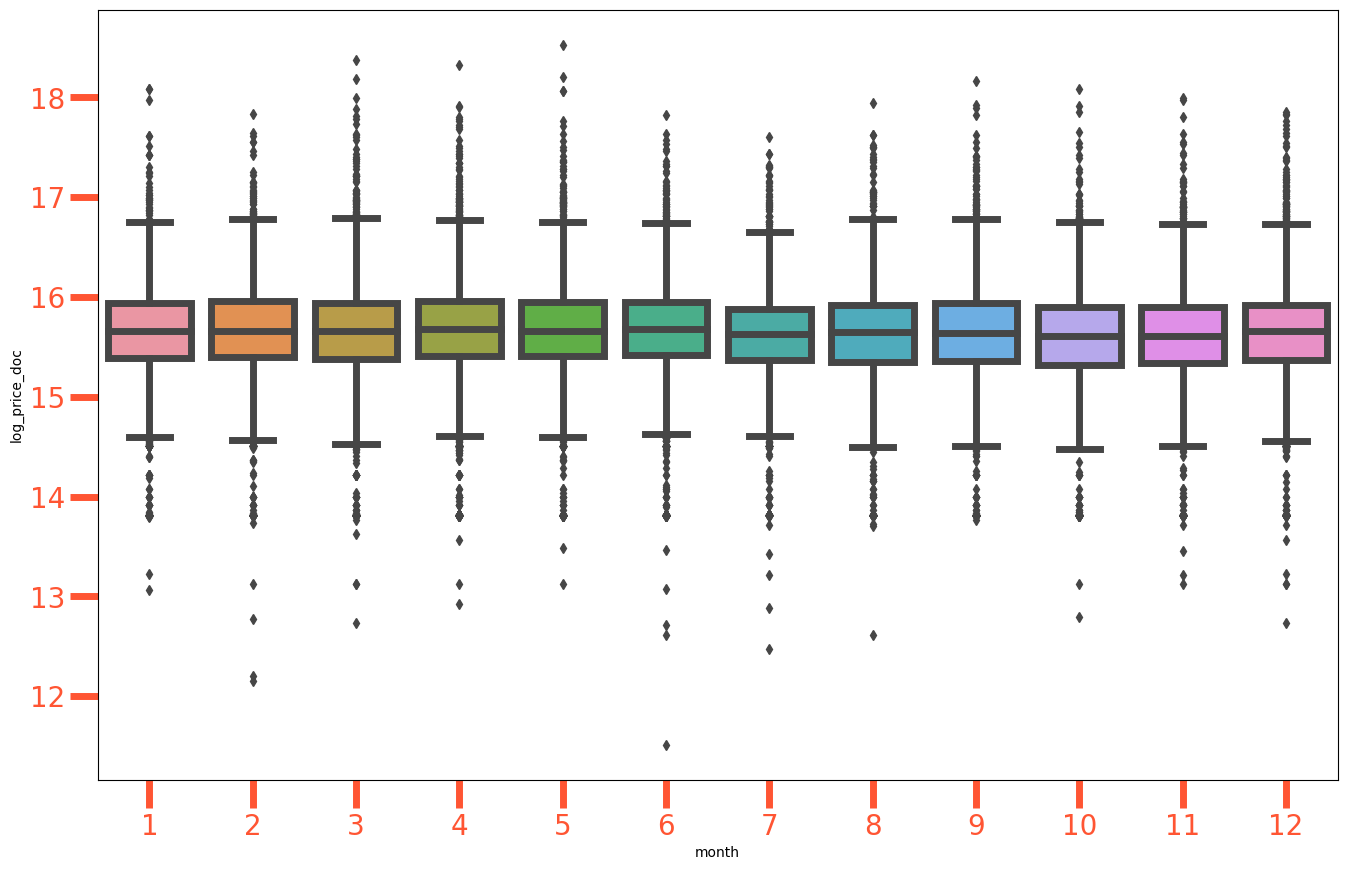

In [25]:
### Target distribution by month

fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.boxplot(y='log_price_doc', x=df['month'].astype('category'), data=df)
plt.show()

In [26]:
### Let's encode the month column using One-Hot

one_hot = pd.get_dummies(df['month'], prefix='month', drop_first=True)
df = pd.concat((df.drop('month', axis=1), one_hot), axis=1)

In [27]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_avto,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_avto_min,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,big_road2_km,railroad_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,cafe_count_1500_price_high,mosque_count_1500,sport_count_1500,market_count_1500,prom_part_2000,office_sqm_2000,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,green_part_3000,prom_part_3000,trc_count_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,year_2012,year_2013,year_2014,year_2015,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,2.590241,0.145700,0.177975,2.158587,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,6.905893,0.274985,0.992631,1.422391,10.918587,1.422391,3.830951,1.305159,24.292406,18.152338,5.718519,1.062513,5.814135,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,7.023705,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,0,6,1,14.27,9,171420,566.67,0,0,7,1,15.97,188854,1244891,614.29,0,1,11.98,13.55,23,1419204,639.68,0,21,1,13.09,13.31,29,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,0.936700,0.147754,0.273345,0.550690,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,4.679745,0.065263

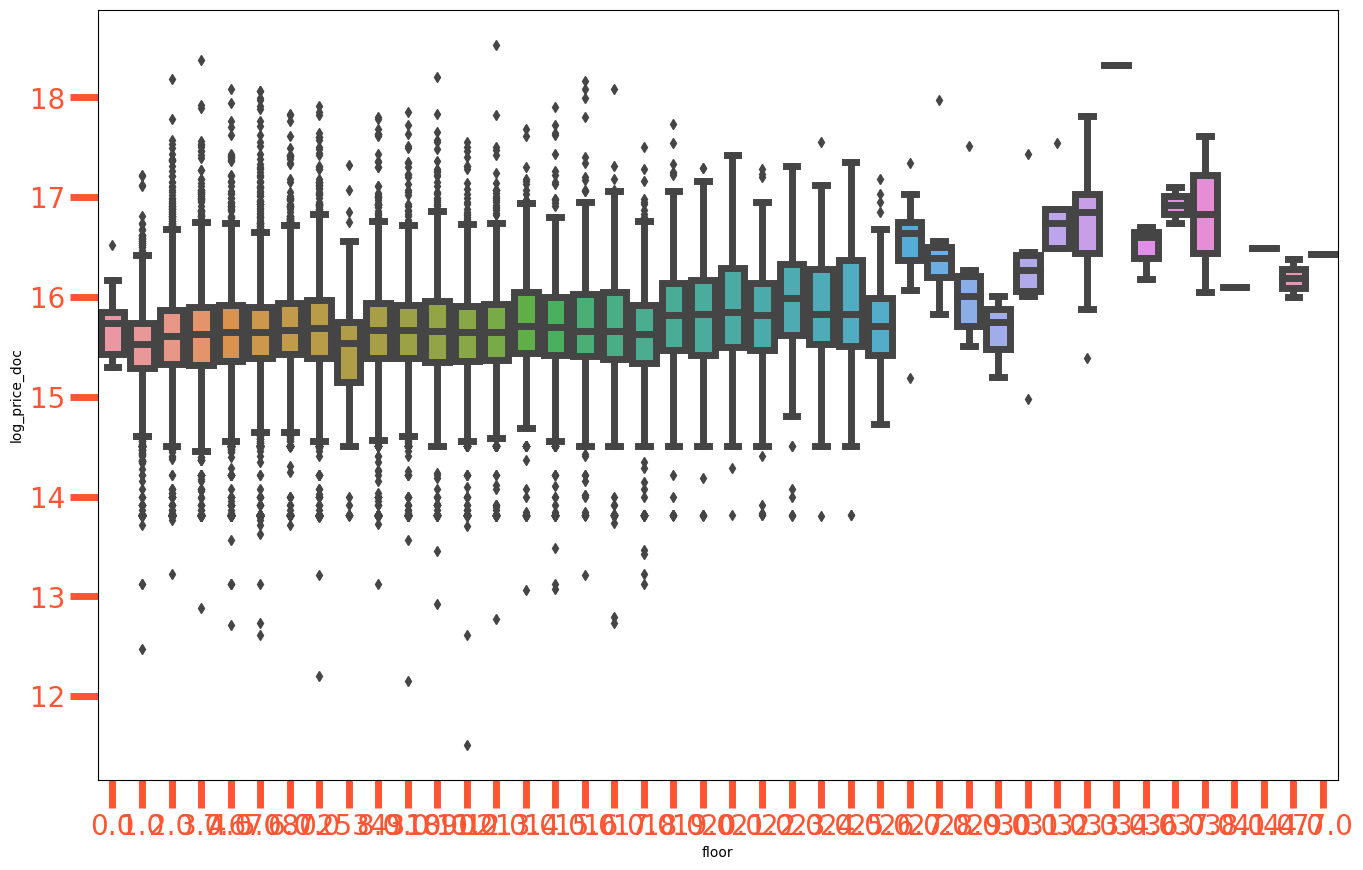

In [28]:
### Target distribution by floor

fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.boxplot(y='log_price_doc', x=df['floor'].astype('category'), data=df)
plt.show()

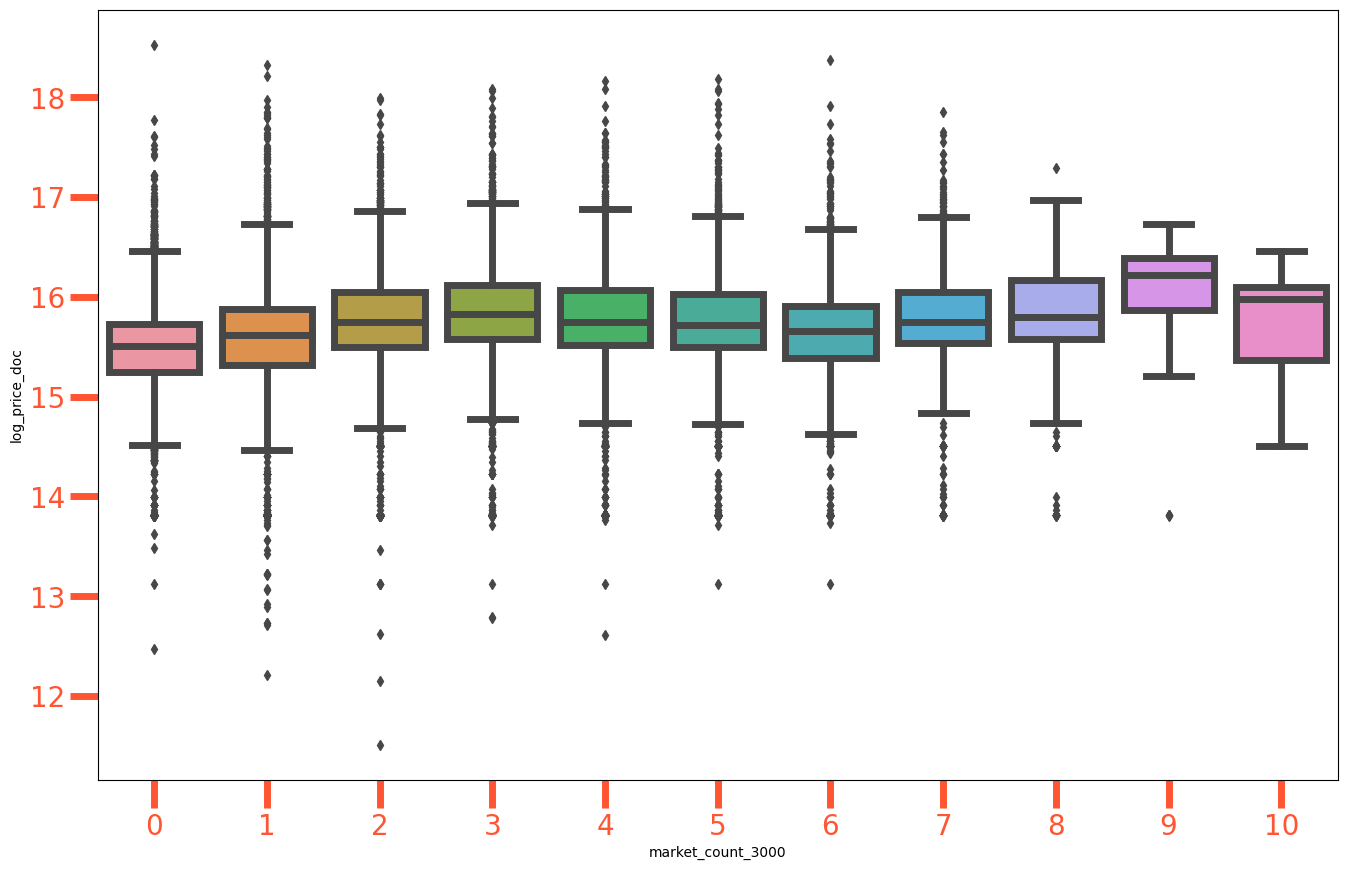

In [29]:
### Target distribution by number of stores within a 3 km radius

fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.boxplot(y='log_price_doc', x=df['market_count_3000'].astype('category'), data=df)
plt.show()

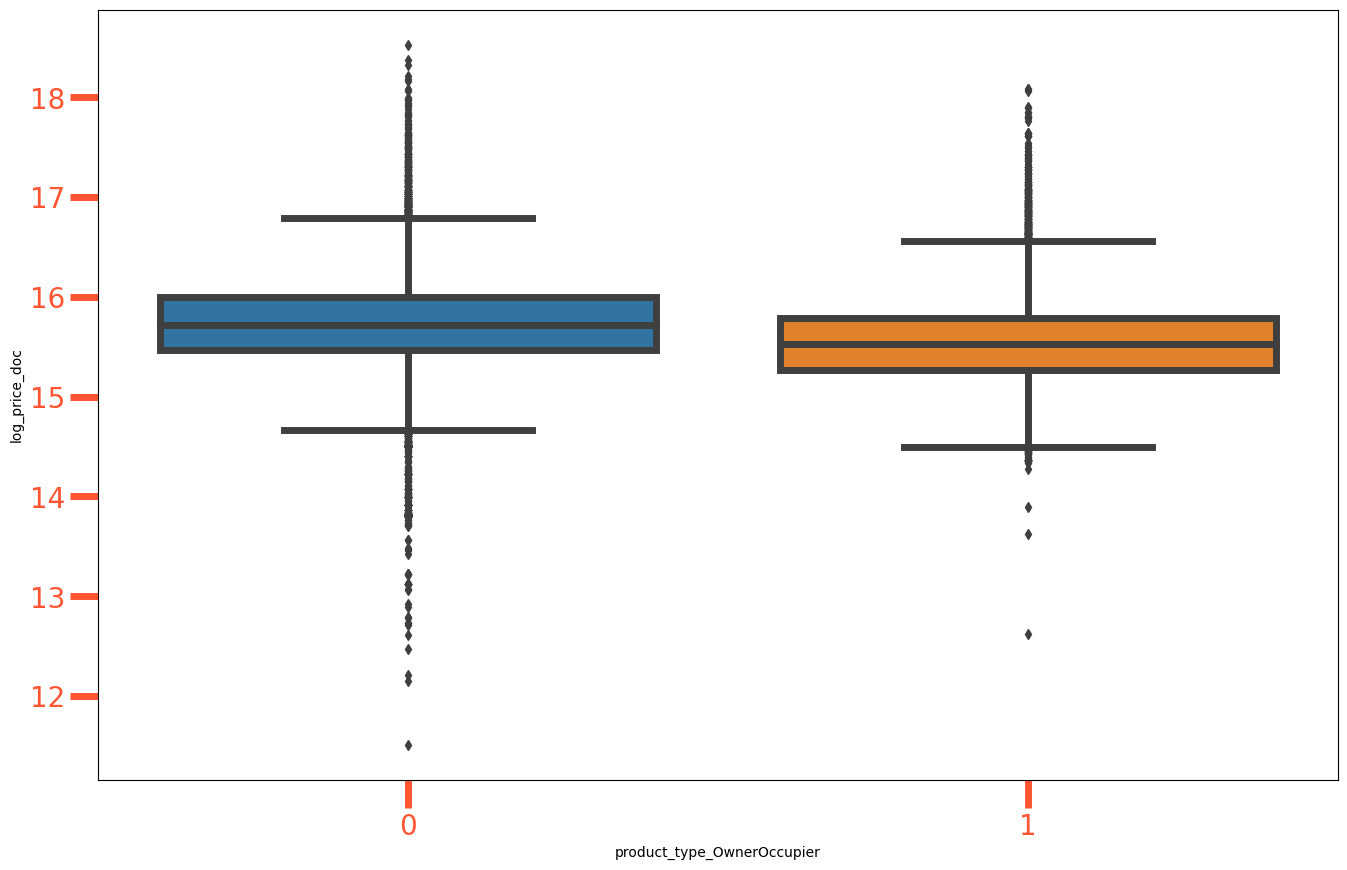

In [30]:
### Target distribution by property type

fig = plt.figure()
fig.set_size_inches(16, 10)

sns.boxplot(y='log_price_doc', x=df['product_type_OwnerOccupier'].astype('category'), data=df)
plt.show()

In [31]:
### Let's remove the timestamp

df = df.drop('timestamp', axis=1)

In [32]:
### Separate targets from objects

X = df.drop('log_price_doc', axis=1)
Y = df['log_price_doc']

## Let's build a couple of basic models as a baseline

Our data now has a time structure. Therefore, to get good generalization ability, we want to build not just a model that works well on new data, but a model that guesses the distribution of data in the future, at least over a short horizon. Therefore, when we validate the model design, it is important for us to divide the train and test at each step in such a way that they do not intersect on the time scale, and points from the second set appear later than points from the first.

Let's establish a "Training base" - a certain set $\{x_t: x_t\in X, t <= T_0 \}$. Further, at each step, we will deviate from it for a certain fixed (for simplicity) interval $T_1$, calling all objects that fall into it validation at the current step. After training the model and measuring the quality, we will add $T_1$ to the training base. We will train the new model on a wider train, and test on data that is more distant in time.

In [33]:
### Let's divide the sample into validation and test

splitter = TimeSeriesSplit(n_splits=4)

In [34]:
### Design for measuring quality at Cross-Validation

test_losses = []
train_losses = []

for train_index, test_index in splitter.split(X):
        
    x_train, x_test = X.values[train_index], X.values[test_index]
    y_train, y_test = Y.values[train_index], Y.values[test_index]
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    preds_test = model.predict(x_test)
    preds_train = model.predict(x_train)
    
    error_test = np.mean((preds_test - y_test)**2)
    error_train = np.mean((preds_train - y_train)**2)
    
    test_losses.append(error_test)
    train_losses.append(error_train)

print(f"Average MSLE on training folds: {np.mean(train_losses).round(3)}")
print(f"Average MSLE on test folds: {np.mean(test_losses).round(3)}")

Average MSLE on training folds: 0.281

Average MSLE on test folds: 0.38


In [35]:
### cross-validate function

model = LinearRegression()

cv_result = cross_validate(model, X, Y, 
                           scoring='neg_mean_squared_error',
                           cv=splitter, return_train_score=True)

cv_result

{'fit_time': array([0.15321708, 0.23180199, 0.33279705, 0.44200706]),
 'score_time': array([0.01021695, 0.01075602, 0.01283383, 0.01158404]),
 'test_score': array([-0.24274306, -0.74526297, -0.235677  , -0.29710867]),
 'train_score': array([-0.32632417, -0.2717254 , -0.26769871, -0.25795313])}

In [36]:
### Let's make sure the results match!

print(f"Average MSLE on training folds: {-np.mean(cv_result['train_score']).round(3)}")
print(f"Average MSLE on test folds: {-np.mean(cv_result['test_score']).round(3)}")

Average MSLE on training folds: 0.281

Average MSLE on test folds: 0.38


In [37]:
### How will the regularization model cope now?
model_lasso = Lasso(max_iter=100000)

cv_result_lasso = cross_validate(model_lasso, X, Y, 
                                 scoring='neg_mean_squared_error',
                                 cv=splitter, return_train_score=True)

print(f"Average MSLE on training folds: {-np.mean(cv_result_lasso['train_score']).round(3)}")
print(f"Average MSLE on test folds: {-np.mean(cv_result_lasso['test_score']).round(3)}")

Average MSLE on training folds: 0.33

Average MSLE on test folds: 0.36


In [38]:
### Let's add data normalization

pipe = Pipeline([('scaler', StandardScaler()), ('Lasso', Lasso(max_iter=100000))])
pipe.fit(X, Y)

print(pipe.predict(X.head(1)))

cv_result_pipe = cross_validate(pipe, X, Y, 
                                scoring='neg_mean_squared_error',
                                cv=splitter, return_train_score=True)

[15.60948317]


In [39]:
print(f"Average MSLE on training folds: {-np.mean(cv_result_pipe['train_score']).round(3)}")
print(f"Average MSLE on test folds: {-np.mean(cv_result_pipe['test_score']).round(3)}")

Average MSLE on training folds: 0.382

Average MSLE on test folds: 0.355


In [40]:
### What are the parameters in our Lego constructor?

pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('Lasso', Lasso(max_iter=100000))],
 'verbose': False,
 'scaler': StandardScaler(),
 'Lasso': Lasso(max_iter=100000),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'Lasso__alpha': 1.0,
 'Lasso__copy_X': True,
 'Lasso__fit_intercept': True,
 'Lasso__max_iter': 100000,
 'Lasso__positive': False,
 'Lasso__precompute': False,
 'Lasso__random_state': None,
 'Lasso__selection': 'cyclic',
 'Lasso__tol': 0.0001,
 'Lasso__warm_start': False}

In [41]:
alphas = np.linspace(start=0.01, stop=1, num=30)
alphas

array([0.01      , 0.04413793, 0.07827586, 0.11241379, 0.14655172,
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ])

In [42]:
### Regularization coefficients

param_grid = {
    "Lasso__alpha": alphas
}

### GridSearchCV

search = GridSearchCV(pipe, param_grid, 
                      cv=splitter, scoring='neg_mean_squared_error')

search.fit(X, Y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=-0.30296):

{'Lasso__alpha': 0.11241379310344828}


In [43]:
pipe.set_params(Lasso__alpha=search.best_params_['Lasso__alpha'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('Lasso', Lasso(alpha=0.11241379310344828, max_iter=100000))])

In [44]:
cv_result_pipe = cross_validate(pipe, X, Y, 
                                scoring='neg_mean_squared_error',
                                cv=splitter, return_train_score=True)

print(f"Average MSLE on training folds: {-np.mean(cv_result_pipe['train_score']).round(3)}")
print(f"Average MSLE on test folds: {-np.mean(cv_result_pipe['test_score']).round(3)}")

Average MSLE on training folds: 0.333

Average MSLE on test folds: 0.303


### Outlier analysis

In [45]:
data = pd.concat((X, Y), axis=1)

In [46]:
top_quantile = data['log_price_doc'].quantile(0.975)
low_quantile = data['log_price_doc'].quantile(0.025)

print(f"Top 2.5% target value: {top_quantile.round(2)}")
print(f"Top 97.5% target value: {low_quantile.round(2)}")

Top 2.5% target value: 16.7

Top 97.5% target value: 13.82


In [47]:
### Let's throw out objects with values outside the segment [top 2.5%; top97.5%]

data = data[(data['log_price_doc']>low_quantile)&(data['log_price_doc']<top_quantile)]

X_new, Y_new = data.drop('log_price_doc', axis=1), data['log_price_doc']

In [48]:
### regularization coefficient

new_splitter = TimeSeriesSplit(n_splits=4)

param_grid = {
    "Lasso__alpha": alphas
}

### We will transfer it to GridSearchCV

search = GridSearchCV(pipe, param_grid, 
                      cv=new_splitter, scoring='neg_mean_squared_error')

search.fit(X_new, Y_new)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=-0.16878):

{'Lasso__alpha': 0.07827586206896552}


In [49]:
pipe.set_params(Lasso__alpha=search.best_params_['Lasso__alpha'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('Lasso', Lasso(alpha=0.07827586206896552, max_iter=100000))])

In [50]:
cv_result_pipe = cross_validate(pipe, X_new, Y_new, 
                                scoring='neg_mean_squared_error',
                                cv=splitter, return_train_score=True)

print(f"Average MSLE on training folds: {-np.mean(cv_result_pipe['train_score']).round(3)}")
print(f"Average MSLE on test folds: {-np.mean(cv_result_pipe['test_score']).round(3)}")

Average MSLE on training folds: 0.17

Average MSLE on test folds: 0.169


### Data segmentation


In [51]:
### Let's divide apartments by property type
### We will build different models for primary and secondary

Owner_Occupier = data[data['product_type_OwnerOccupier'] == 1].copy()
Investment = data[data['product_type_OwnerOccupier'] == 0].copy()

In [52]:
X_Occupier = Owner_Occupier.drop('log_price_doc', axis=1)
X_Investment = Investment.drop('log_price_doc', axis=1)

Y_Occupier = Owner_Occupier['log_price_doc']
Y_Investment = Investment['log_price_doc']

In [53]:
### Let's assemble a model for Owner_Occupier

search_Owner_Occupier = GridSearchCV(pipe, param_grid, 
                                     cv=splitter, scoring='neg_mean_squared_error')

search_Owner_Occupier.fit(X_Occupier, Y_Occupier)

print(f"Best parameter (CV score={search_Owner_Occupier.best_score_:.5f}):")
print(search_Owner_Occupier.best_params_)

pipe.set_params(Lasso__alpha=search_Owner_Occupier.best_params_['Lasso__alpha'])

cv_result_pipe = cross_validate(pipe, X_Occupier, Y_Occupier, 
                                scoring='neg_mean_squared_error',
                                cv=splitter, return_train_score=True)

error_Occupier_train = -np.mean(cv_result_pipe['train_score'])
error_Occupier_test = -np.mean(cv_result_pipe['test_score'])

print(f"Average MSLE on training folds: {error_Occupier_train.round(3)}")
print(f"Average MSLE on test folds: {error_Occupier_test.round(3)}")

Best parameter (CV score=-0.08234):

{'Lasso__alpha': 0.04413793103448276}

Average MSLE on training folds: 0.072

Average MSLE on test folds: 0.082


In [54]:
### Let's assemble a model for Investment

search_Investment = GridSearchCV(pipe, param_grid, 
                                cv=splitter, scoring='neg_mean_squared_error')

search_Investment.fit(X_Investment, Y_Investment)

print(f"Best parameter (CV score={search_Investment.best_score_:.5f}):")
print(search_Investment.best_params_)

pipe.set_params(Lasso__alpha=search_Investment.best_params_['Lasso__alpha'])

cv_result_pipe = cross_validate(pipe, X_Investment, Y_Investment, 
                                scoring='neg_mean_squared_error',
                                cv=splitter, return_train_score=True)

error_Investment_train = -np.mean(cv_result_pipe['train_score'])
error_Investment_test = -np.mean(cv_result_pipe['test_score'])

print(f"Average MSLE on training folds: {error_Investment_train.round(3)}")
print(f"Average MSLE on test folds: {error_Investment_test.round(3)}")

Best parameter (CV score=-0.17547):

{'Lasso__alpha': 0.01}

Average MSLE on training folds: 0.181

Average MSLE on test folds: 0.175


In [55]:
### Let's reweight the rates taking into account the number of objects in both types of housing

n_Occupier = Owner_Occupier.shape[0]
n_Investment = Investment.shape[0] 

## Let's calculate the shares of categories in the total sample 

share_Occupier = n_Occupier / data.shape[0]
share_Investment = n_Investment / data.shape[0]

weighted_error_train = share_Occupier * error_Occupier_train + \
                       share_Investment * error_Investment_train

weighted_error_test = share_Occupier * error_Occupier_test + \
                       share_Investment * error_Investment_test

print(f"Average MSLE on training folds: {weighted_error_train.round(3)}")
print(f"Average MSLE on test folds: {weighted_error_test.round(3)}")

Average MSLE on training folds: 0.14

Average MSLE on test folds: 0.14


How else can the model be improved? A few areas to think about:

- Train other models
- Add macro indicators to the dataset
- Generate new features from existing ones (not simple encoding)
- Conduct a more in-depth EDA analysis